In [1]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, merge, Activation, Flatten
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import nltk

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
token = 'Flickr8k_text/Flickr8k.token.txt'

In [3]:
captions = open(token, 'r').read().strip().split('\n')

In [4]:
d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]

In [5]:
d['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [6]:
images = 'Flickr8k_Dataset/Flicker8k_Dataset/'

In [7]:
# Contains all the images
img = glob.glob(images+'*.jpg')

In [8]:
img[:5]

['Flickr8k_Dataset/Flicker8k_Dataset\\1000268201_693b08cb0e.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset\\1001773457_577c3a7d70.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset\\1002674143_1b742ab4b8.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset\\1003163366_44323f5815.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset\\1007129816_e794419615.jpg']

In [9]:
train_images_file = 'Flickr8k_text/Flickr_8k.trainImages.txt'

In [10]:
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

In [11]:
def split_data(l):
    temp = []
    for i in img:
        if i[len(images):] in l:
            temp.append(i)
    return temp

In [12]:
# Getting the training images from all the images
train_img = split_data(train_images)
len(train_img)

6000

In [13]:
val_images_file = 'Flickr8k_text/Flickr_8k.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))

In [14]:
# Getting the validation images from all the images
val_img = split_data(val_images)
len(val_img)

1000

In [15]:
test_images_file = 'Flickr8k_text/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

In [16]:
# Getting the testing images from all the images
test_img = split_data(test_images)
len(test_img)

1000

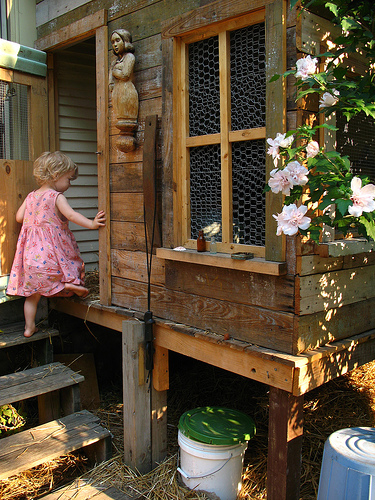

In [17]:
Image.open(train_img[0])

In [18]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [19]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


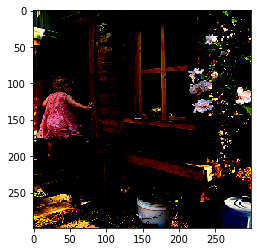

In [20]:
plt.imshow(np.squeeze(preprocess(train_img[0])))

In [21]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
model = InceptionV3(weights='imagenet')


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



Instructions for updating:
keep_dims is deprecated, use keepdims instead





In [22]:
from keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

In [23]:
tryi = model_new.predict(preprocess(train_img[0]))

In [24]:
tryi.shape

(1, 2048)

In [25]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

In [26]:
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)

100%|██████████| 6000/6000 [-3:35:43<00:00, -0.69it/s]


In [27]:
with open("encoded_images_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle) 

In [28]:
encoding_train = pickle.load(open('encoded_images_inceptionV3.p', 'rb'))

In [29]:
encoding_train['3556792157_d09d42bef7.jpg'].shape

(2048,)

In [30]:
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)

100%|██████████| 1000/1000 [03:37<00:00,  4.59it/s]


In [31]:
with open("encoded_images_test_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle) 

In [32]:
encoding_test = pickle.load(open('encoded_images_test_inceptionV3.p', 'rb'))

In [33]:
encoding_test[test_img[0][len(images):]].shape

(2048,)

In [34]:
train_d = {}
for i in train_img:
    if i[len(images):] in d:
        train_d[i] = d[i[len(images):]]

In [35]:
len(train_d)

6000

In [36]:
train_d[images+'3556792157_d09d42bef7.jpg']

KeyError: 'Flickr8k_Dataset/Flicker8k_Dataset/3556792157_d09d42bef7.jpg'

In [37]:
val_d = {}
for i in val_img:
    if i[len(images):] in d:
        val_d[i] = d[i[len(images):]]

In [38]:
len(val_d)

1000

In [39]:
test_d = {}
for i in test_img:
    if i[len(images):] in d:
        test_d[i] = d[i[len(images):]]

In [40]:
len(test_d)

1000

In [41]:
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [42]:
words = [i.split() for i in caps]

In [43]:
unique = []
for i in words:
    unique.extend(i)

In [44]:
unique = list(set(unique))

In [45]:
# with open("unique.p", "wb") as pickle_d:
#     pickle.dump(unique, pickle_d) 

In [46]:
unique = pickle.load(open('unique.p', 'rb'))

In [47]:
len(unique)

8256

In [48]:
word2idx = {val:index for index, val in enumerate(unique)}

In [49]:
word2idx['<start>']

5553

In [50]:
idx2word = {index:val for index, val in enumerate(unique)}

In [51]:
idx2word[5553]

'<start>'

In [52]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

40

In [53]:
len(unique), max_len

(8256, 40)

In [54]:
vocab_size = len(unique)

In [55]:
vocab_size

8256

In [56]:
f = open('flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

In [57]:
for key, val in train_d.items():
    for i in val:
        f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [58]:
df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')

In [59]:
len(df)

30000

In [60]:
c = [i for i in df['captions']]
len(c)

30000

In [61]:
imgs = [i for i in df['image_id']]

In [62]:
a = c[-1]
a, imgs[-1]

('<start> Woman writing on a pad in room with gold , decorated walls . <end>',
 '997338199_7343367d7f.jpg')

In [63]:
for i in a.split():
    print (i, "=>", word2idx[i])

<start> => 5553
Woman => 860
writing => 3643
on => 803
a => 32
pad => 6042
in => 8156
room => 7022
with => 4350
gold => 8122
, => 5672
decorated => 4539
walls => 7915
. => 7023
<end> => 5232


In [64]:
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [65]:
samples_per_epoch

383454

In [66]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

In [67]:
embedding_size = 300

In [68]:
image_model = Sequential([
        Dense(embedding_size, input_shape=(2048,), activation='relu'),
        RepeatVector(max_len)
    ])

In [69]:
caption_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(300))
    ])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [70]:
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten , Merge


In [71]:
final_model = Sequential([
        Merge([image_model, caption_model], mode='concat', concat_axis=1),
        Bidirectional(LSTM(256, return_sequences=False)),
        Dense(vocab_size),
        Activation('softmax')
    ])

In [72]:
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [73]:
final_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 300)           614700                                       
____________________________________________________________________________________________________
repeatvector_1 (RepeatVector)    (None, 40, 300)       0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 40, 300)       2476800                                      
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 40, 256)       570368                                       
___________________________________________________________________________________________

In [83]:
final_model.fit_generator(data_generator(batch_size=128),  samples_per_epoch = samples_per_epoch//128 , nb_epoch=1, 
                          verbose=2)

Epoch 1/1


C:\Users\rdhen\Anaconda3\lib\site-packages\keras\engine\training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


64s - loss: 3.6998 - acc: 0.3584


In [84]:
final_model.fit_generator(data_generator(batch_size=128),  samples_per_epoch = samples_per_epoch//128 , nb_epoch=1, 
                          verbose=2)

Epoch 1/1
61s - loss: 3.7197 - acc: 0.3698


In [85]:
final_model.fit_generator(data_generator(batch_size=128),  samples_per_epoch = samples_per_epoch//128 , nb_epoch=1, 
                          verbose=2)

Epoch 1/1
58s - loss: 3.6978 - acc: 0.3672


In [86]:
final_model.fit_generator(data_generator(batch_size=128),  samples_per_epoch = samples_per_epoch//128 , nb_epoch=1, 
                          verbose=2)

Epoch 1/1
59s - loss: 3.7200 - acc: 0.3607


In [87]:
final_model.fit_generator(data_generator(batch_size=128),  samples_per_epoch = samples_per_epoch//128 , nb_epoch=1, 
                          verbose=2)

Epoch 1/1
60s - loss: 3.6711 - acc: 0.3717


In [88]:
final_model.fit_generator(data_generator(batch_size=128),  samples_per_epoch = samples_per_epoch//128 , nb_epoch=1, 
                          verbose=2)

Epoch 1/1
59s - loss: 3.7593 - acc: 0.3695


In [89]:
final_model.optimizer.lr = 1e-4
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch = samples_per_epoch//128, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
58s - loss: 3.8761 - acc: 0.3532


In [90]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch = samples_per_epoch//128, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
58s - loss: 3.6411 - acc: 0.3675


In [91]:
final_model.save_weights('time_inceptionV3_7_loss_3.2604.h5')

In [92]:
final_model.load_weights('time_inceptionV3_7_loss_3.2604.h5')

In [93]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch = samples_per_epoch//128, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
65s - loss: 3.6312 - acc: 0.3532


In [94]:
final_model.fit_generator(data_generator(batch_size=128),samples_per_epoch = samples_per_epoch//128, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
63s - loss: 3.6533 - acc: 0.3691


In [109]:
final_model.save_weights('time_inceptionV3_3.21_loss.h5')

In [110]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch//128, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
63s - loss: 3.5338 - acc: 0.3685


In [111]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch//128, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
63s - loss: 3.5674 - acc: 0.3760


In [112]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch//128, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
70s - loss: 3.5814 - acc: 0.3753


In [107]:
final_model.save_weights('time_inceptionV3_3.15_loss.h5')

In [108]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch//128, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
65s - loss: 3.5551 - acc: 0.3649


In [113]:
final_model.load_weights('time_inceptionV3_3.15_loss.h5')

In [114]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, merge, Activation, Flatten
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import nltk

## Predict funtion

In [115]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images):]]
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [116]:
def beam_search_predictions(image, beam_index = 3):
    start = [word2idx["<start>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            e = encoding_test[image[len(images):]]
            preds = final_model.predict([np.array([e]), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

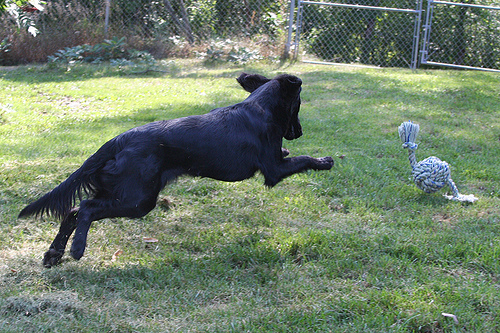

In [117]:
try_image = test_img[5]
Image.open(try_image)

In [118]:
print ('Normal Max search:', predict_captions(try_image)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image, beam_index=7))

Normal Max search: A black dog is running through the grass .
Beam Search, k=3: A black dog runs through the grass .
Beam Search, k=5: A black dog runs through the grass .
Beam Search, k=7: A black dog runs through the grass .


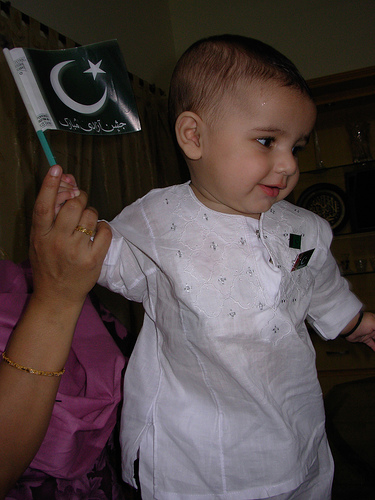

In [119]:
try_image2 = test_img[7]
Image.open(try_image2)

In [120]:
print ('Normal Max search:', predict_captions(try_image2)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image2, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image2, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image2, beam_index=7))

Normal Max search: A little girl is holding a baby .
Beam Search, k=3: A little girl in a red shirt is holding a baby .
Beam Search, k=5: A little girl in a red shirt is holding a ball .
Beam Search, k=7: A little girl in a red shirt is holding a ball .


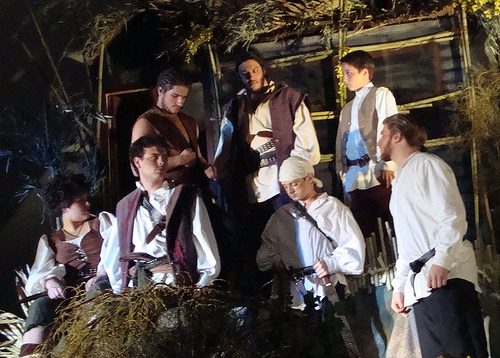

In [121]:
try_image3 = test_img[851]
Image.open(try_image3)

In [122]:
print ('Normal Max search:', predict_captions(try_image3)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image3, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image3, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image3, beam_index=7))

Normal Max search: A man in a black shirt and white and white shirt and a black shirt is standing in the background .
Beam Search, k=3: Two people are standing in the street .
Beam Search, k=5: A group of people standing in the street .
Beam Search, k=7: A group of people are standing in front of a building .


In [ ]:
try_image4 = 'Flickr8k_Dataset/Flicker8k_Dataset/136552115_6dc3e7231c.jpg'
print ('Normal Max search:', predict_captions(try_image4))
print ('Beam Search, k=3:', beam_search_predictions(try_image4, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image4, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image4, beam_index=7))
Image.open(try_image4)

In [ ]:
im = 'Flickr8k_Dataset/Flicker8k_Dataset/1674612291_7154c5ab61.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

In [ ]:
im = 'Flickr8k_Dataset/Flicker8k_Dataset/384577800_fc325af410.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

In [ ]:
im = 'Flickr8k_Dataset/Flicker8k_Dataset/3631986552_944ea208fc.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

In [ ]:
im = 'Flickr8k_Dataset/Flicker8k_Dataset/3320032226_63390d74a6.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

In [ ]:
im = 'Flickr8k_Dataset/Flicker8k_Dataset/3316725440_9ccd9b5417.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

In [ ]:
im = 'Flickr8k_Dataset/Flicker8k_Dataset/2306674172_dc07c7f847.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

In [ ]:
im = 'Flickr8k_Dataset/Flicker8k_Dataset/2542662402_d781dd7f7c.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

In [ ]:
im = test_img[int(np.random.randint(0, 1000, size=1))]
print (im)
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)